In [67]:
using ForwardDiff
using Printf
using Gadfly
using PorousMaterials
using Colors
using ColorSchemes
using Compose
using LaTeXStrings
using DataFrames

# Gadfly plotting theme
theme = Theme(minor_label_font_size=16pt, major_label_font_size=16pt, 
    key_title_font_size=16pt, point_label_font_size=16pt, key_label_font_size=14pt,
    line_width=3pt);

default_discrete_colors(n) = convert(Vector{Color},
        distinguishable_colors(n,
                               [LCHab(70, 60, 240)],
                               transform=c -> deuteranopic(c, 0.5),
                               lchoices=Float64[65, 70, 75, 80],
                               cchoices=Float64[0, 50, 60, 70],
                               hchoices=range(0, stop=330, length=24)))
default_discrete_colors(5)

# Data structure for a MORF
* $\delta$ is...
* $\epsilon_\heartsuit$ is...
* $\epsilon_\Delta$ is...


We define _material space_ to be $( \delta, \epsilon_\heartsuit, \epsilon_\triangle)$.

In [68]:
struct Material
    δ::Float64
    ϵ♡::Float64
    ϵΔ::Float64
end

function Base.show(io::IO, material::Material)
    @printf("MORF material with:\n\tδ = %.3f\n\tϵ♡ = %.3f\n\tϵΔ = %.3f\n", material.δ, material.ϵ♡, material.ϵΔ)
end

# example use
material = Material(1.0, -3.0, 4.0)

MORF material with:
	δ = 1.000
	ϵ♡ = -3.000
	ϵΔ = 4.000


# Adsorption isotherm of a MORF

\begin{equation}
    \langle n \rangle(P) = \dfrac{K \beta P}{1+K \beta P}
\end{equation} where:
\begin{equation}
K=K(\beta; \delta, \epsilon_\heartsuit, \epsilon_\triangle)=\dfrac{1}{1+e^{-\beta\delta}}e^{-\beta \epsilon_\triangle} + \dfrac{e^{-\beta\delta}}{1+e^{-\beta\delta}}e^{-\beta \epsilon_\heartsuit}
\end{equation}.

In [34]:
function K(material::Material, β::Real) # must assert β::Real as opposed to β::Float64 for ForwardDiff.jl to work
    p = 1 / (1 + exp(-β * material.δ)) # probability ring is on ♡ when gas is absent
    return p * exp(-β * material.ϵΔ) + (1 - p) * exp(-β * material.ϵ♡)
end

function expected_n(material::Material, β::Float64, P::Float64)
    return K(material, β) * β * P / (1.0 + K(material, β) * β * P)
end

expected_n (generic function with 1 method)

# Searching for anamolous behavior

## Can $\langle n \rangle$ *increase* when temperature increases?
i.e. is there a region of material space and a temperature $\beta$ such that:
\begin{equation}
   \left( \dfrac{\partial \langle n \rangle}{\partial \beta} \right)_P <0?
\end{equation}

let's use auto-differentiation to computationally explore material space and $\beta$ to see if this happens.

We proved that the following quantity has the same sign as $\partial \langle n \rangle / \partial \beta$:
\begin{equation}
   \left( \dfrac{\partial (K\beta)}{\partial \beta} \right)_P .
\end{equation}

In [69]:
function ∂Kβ_∂β(material::Material, β::Float64)
    # view K as a function of β only.
    Kβ(x) = K(material, x[1]) * x[1] # x plays role of β
    ∂Kβ_∂β_of_β = x -> ForwardDiff.gradient(Kβ, x) # x plays role of β
    return ∂Kβ_∂β_of_β([β])[1]
end

∂Kβ_∂β (generic function with 1 method)

assert that $\dfrac{d(K\beta)}{d\beta}$ is a function of $(\beta \delta, \beta \epsilon_\triangle, \beta \epsilon_\heartsuit)$ only, as pencil and paper math suggests.

In [70]:
@assert isapprox(∂Kβ_∂β(Material(2.4, -1.45, -6.7), 1.0), ∂Kβ_∂β(Material(2.4 * 3, -1.45 * 3, -6.7 * 3), 1.0 / 3))

search param space  $(\beta \delta, \beta \epsilon_\triangle, \beta \epsilon_\heartsuit)$ for anamolous behavior. store in a grid and write as a `.cube` file for viz

In [72]:
nb_pts = 25
max_βE = 50.0
βδ_range = range(0.0, stop=max_βE, length=nb_pts)
βϵ♡_range = range(-max_βE, stop=0.0, length=nb_pts)
βϵΔ_range = range(-max_βE, stop=0.0, length=nb_pts)
# b/c it's really only a function of (βδ, βϵ♡, βϵΔ) [see pencil and paper math]
β = 1.0

box = Box(max_βE, max_βE, max_βE, π/2, π/2, π/2)
grid = Grid(box, (nb_pts, nb_pts, nb_pts), zeros(Float64, nb_pts, nb_pts, nb_pts), :wutevs,
    [0.0, -max_βE, -max_βE])

for (i, βδ) in enumerate(βδ_range)
    for (j, βϵ♡) in enumerate(βϵ♡_range)
        for (k, βϵΔ) in enumerate(βϵΔ_range)
            material = Material(βδ, βϵ♡, βϵΔ)
            grid.data[i, j, k] = ∂Kβ_∂β(material, β)
            # Looking at henry's law
            if ∂Kβ_∂β(material, β) < 0.0
                println("∂⟨n⟩/∂β < 0! ", material)
            end
        end
    end
end

isdir("data") ? nothing : mkdir("data")
write_cube(grid, "∂Kβ_∂β.cube")

∂⟨n⟩/∂β < 0! MORF material with:
	δ = 37.500
	ϵ♡ = -50.000
	ϵΔ = -12.500

∂⟨n⟩/∂β < 0! MORF material with:
	δ = 37.500
	ϵ♡ = -50.000
	ϵΔ = -10.417

∂⟨n⟩/∂β < 0! MORF material with:
	δ = 37.500
	ϵ♡ = -50.000
	ϵΔ = -8.333

∂⟨n⟩/∂β < 0! MORF material with:
	δ = 37.500
	ϵ♡ = -50.000
	ϵΔ = -6.250

∂⟨n⟩/∂β < 0! MORF material with:
	δ = 37.500
	ϵ♡ = -50.000
	ϵΔ = -4.167

∂⟨n⟩/∂β < 0! MORF material with:
	δ = 37.500
	ϵ♡ = -50.000
	ϵΔ = -2.083

∂⟨n⟩/∂β < 0! MORF material with:
	δ = 37.500
	ϵ♡ = -50.000
	ϵΔ = 0.000

∂⟨n⟩/∂β < 0! MORF material with:
	δ = 37.500
	ϵ♡ = -47.917
	ϵΔ = -10.417

∂⟨n⟩/∂β < 0! MORF material with:
	δ = 37.500
	ϵ♡ = -47.917
	ϵΔ = -8.333

∂⟨n⟩/∂β < 0! MORF material with:
	δ = 37.500
	ϵ♡ = -47.917
	ϵΔ = -6.250

∂⟨n⟩/∂β < 0! MORF material with:
	δ = 37.500
	ϵ♡ = -47.917
	ϵΔ = -4.167

∂⟨n⟩/∂β < 0! MORF material with:
	δ = 37.500
	ϵ♡ = -47.917
	ϵΔ = -2.083

∂⟨n⟩/∂β < 0! MORF material with:
	δ = 37.500
	ϵ♡ = -47.917
	ϵΔ = 0.000

∂⟨n⟩/∂β < 0! MORF material with:
	δ = 37.500
	ϵ♡ =

MORF material with:
	δ = 37.500
	ϵ♡ = -50.000
	ϵΔ = -12.500
∂(Kβ)/∂β = 1.915286276098931e6
∂(Kβ)/∂β = 2.432326844940444e6
∂(Kβ)/∂β = 2.1645667845116984e6
∂(Kβ)/∂β = 3.40123195479668e6
∂(Kβ)/∂β = 2.997934655988398e6
∂(Kβ)/∂β = 9.304651415361363e6
∂(Kβ)/∂β = -5.306747156026895e6
∂(Kβ)/∂β = -6.4400948765009865e6
∂(Kβ)/∂β = -7.8137579388640495e6
∂(Kβ)/∂β = -9.478383118697975e6
∂(Kβ)/∂β = -1.1495235229022782e7
∂(Kβ)/∂β = -1.3938413052365087e7
∂(Kβ)/∂β = -1.689752588053688e7
∂(Kβ)/∂β = -2.048092606671695e7
∂(Kβ)/∂β = -2.481961269316296e7


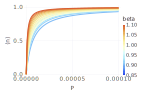

In [76]:
material = Material(37.500, -50.000, -12.500)
print(material)

df = DataFrame(beta=Float64[], P=Float64[], n=Float64[])
Ps = range(0.0, stop=.0001, length=100)
βs = range(0.9, stop=1.1, length=15)
for β in βs
    println("∂(Kβ)/∂β = ", ∂Kβ_∂β(material, β))
    for P in Ps
        n = expected_n(material, β, P)
        push!(df, [β, P, n])
    end
end

plot(df, x=:P, y=:n, color=:beta,
     Guide.xlabel("P"),
     Guide.ylabel("⟨n⟩"),
     Geom.line,
     Scale.color_continuous(colormap=c -> get(ColorSchemes.lighttemperaturemap, c)),
     theme)

# ring position

\begin{equation}
    \langle r \rangle = 
   \left(\frac{e^{-\beta \delta}}{1+e^{-\beta \delta}} \right)
   \left( \frac{1+e^{-\beta \epsilon_\heartsuit}\lambda}{1+K\lambda}\right),
\end{equation}

In [31]:
function expected_r(material::Material, β::Float64, λ::Float64)
    p_Δ = exp(-β * material.δ) / (1 + exp(-β * material.δ))
    return p_Δ * (1 + exp(-β * material.ϵ♡) * λ) / (1 + K(material, β) * λ)
end

expected_r (generic function with 1 method)

### show dependence on gas uptake

material where gas loves Δ: MORF material with:
	δ = 1.000
	ϵ♡ = -2.000
	ϵΔ = -4.000

material where gas loves ♡: MORF material with:
	δ = 1.000
	ϵ♡ = -4.000
	ϵΔ = -2.000



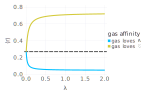

In [32]:
material_gas_loves_Δ = Material(1.0, -2.0, -4.0)
material_gas_loves_♡ = Material(1.0, -4.0, -2.0)
@assert isapprox(material_gas_loves_♡.δ, material_gas_loves_Δ.δ)

println("material where gas loves Δ: ", material_gas_loves_Δ)
println("material where gas loves ♡: ", material_gas_loves_♡)

r_no_gas = exp(-material_gas_loves_♡.δ) / (1 + exp(-material_gas_loves_♡.δ))

λ = range(0.0, stop=2.0, length=300)
r_gas_loves_Δ = [expected_r(material_gas_loves_Δ, 1.0, λ_i) for λ_i in λ]
r_gas_loves_♡ = [expected_r(material_gas_loves_♡, 1.0, λ_i) for λ_i in λ]

# annotation = compose(context(), 
#     text(1.6, 0.5, @sprintf("βδ=%d", material_gas_loves_♡.δ)), 
#     fontsize(10pt))

plot(layer(x=λ, y=r_gas_loves_Δ, Geom.line, 
        Theme(default_color=default_discrete_colors(2)[1], line_width=3pt)),
     layer(x=λ, y=r_gas_loves_♡, Geom.line,
        Theme(default_color=default_discrete_colors(2)[2], line_width=3pt)),
     Guide.xlabel("λ"),
     Guide.ylabel("⟨r⟩"),
     Geom.hline(style=:dash, color="black", size=2pt), yintercept=[r_no_gas],
     Guide.manual_color_key("gas affinity", ["gas loves Δ","gas loves ♡"],
                            default_discrete_colors(2)),
#      Guide.annotation(annotation),
     theme)

### show dependence on temperature (an interesting case)

this is a property dependent on $n$.

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[56]:16
└ @ Core In[56]:16


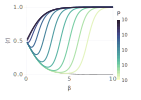

In [56]:
material = Material(1.0, -3.0, -1.0)
β = range(0.1, stop=10.0, length=100)

P = 10. .^ (-7:2)

df = DataFrame(beta=Float64[], P=Float64[], r=Float64[])
r = zeros(length(β), length(P))
for i = 1:length(β)
    for j = 1:length(P)
        r = expected_r(material, β[i], β[i] * P[j])
        push!(df, [β[i], P[j], r])
    end
end

r_no_gas = exp.(-β * material.δ) ./ (1.0 .+ exp.(-β * material.δ))
    
plot(df[df[:P] .> 0.0, :], color=:P, Geom.line, x=:beta, y=:r,
     Guide.xlabel("β"),
     Guide.ylabel("⟨r⟩"),
     layer(x=β, y=r_no_gas, Geom.line, Theme(default_color=colorant"black")),
#      Guide.manual_color_key("pressure", [@sprintf("P = %.1e", P[i]) for i = 1:length(P)],
#                             greenz),
      Scale.color_log10(colormap=c -> get(ColorSchemes.deep, c)),
     theme)